# Transfer Learning with MobileNetV2

## 1 - Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


### 1.1 Create the Dataset and Split it into Training and Validation Sets

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


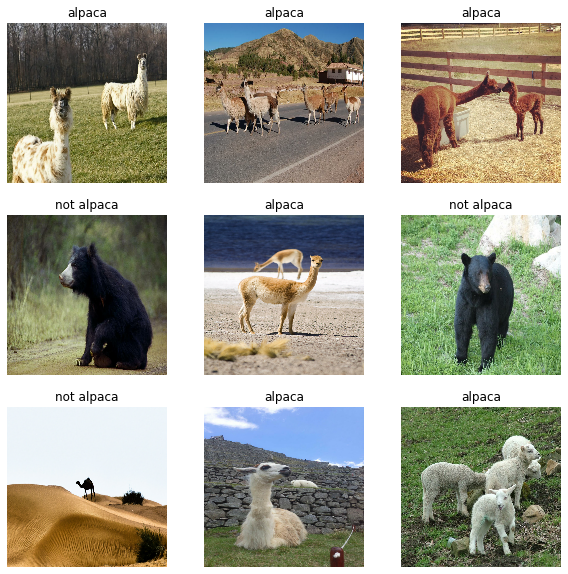

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 2 - Preprocess and Augment Training Data

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))    
    return data_augmentation

augmenter = data_augmenter()

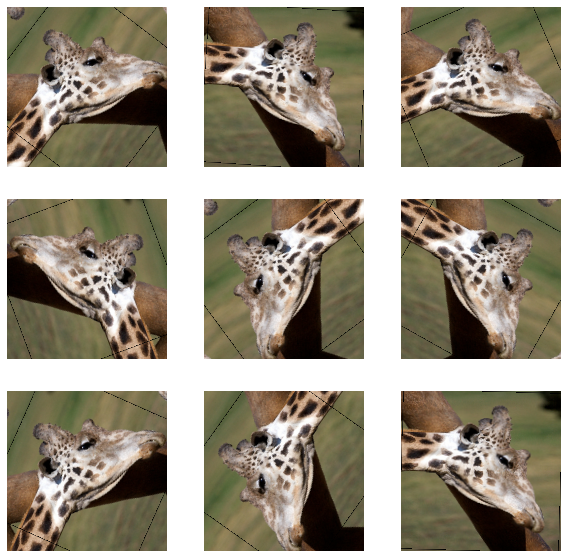

In [6]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## 3 - Using MobileNetV2 for Transfer Learning 


In [8]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [9]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [10]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
print(label_batch)

(32, 1000)
tf.Tensor([1 0 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0], shape=(32,), dtype=int32)


In [12]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n04589890', 'window_screen', 0.42582178),
  ('n02708093', 'analog_clock', 0.092755705)],
 [('n04589890', 'window_screen', 0.23985943),
  ('n03887697', 'paper_towel', 0.14802644)],
 [('n04589890', 'window_screen', 0.74494576),
  ('n03598930', 'jigsaw_puzzle', 0.021948546)],
 [('n04589890', 'window_screen', 0.33545998),
  ('n03530642', 'honeycomb', 0.076289706)],
 [('n04589890', 'window_screen', 0.27327403),
  ('n03733281', 'maze', 0.08846925)],
 [('n04589890', 'window_screen', 0.6745238),
  ('n03530642', 'honeycomb', 0.07659912)],
 [('n04589890', 'window_screen', 0.79128563),
  ('n04209239', 'shower_curtain', 0.092415996)],
 [('n04589890', 'window_screen', 0.16462992),
  ('n03598930', 'jigsaw_puzzle', 0.0874913)],
 [('n03598930', 'jigsaw_puzzle', 0.370213),
  ('n04589890', 'window_screen', 0.09956957)],
 [('n04589890', 'window_screen', 0.61616504),
  ('n03887697', 'paper_towel', 0.054876436)],
 [('n03530642', 'honeycomb', 0.2544885),
  ('n04589890', 'window_screen', 0.24874304)],
 [

### Layer Freezing with the Functional API

In [13]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
   
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    
    # base model freezed by making it non trainable
    base_model.trainable = False 

    # input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # data augmentation applied to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Binary classification layers
    # global avg pooling to summarize the info in each channel
    x = tfl.GlobalAvgPool2D()(x) 
    # dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(1)
        
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [14]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [15]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 6s 666ms/step - loss: 0.8013 - accuracy: 0.5420 - val_loss: 0.5851 - val_accuracy: 0.5846
Epoch 2/5
9/9 [==============================] - 4s 449ms/step - loss: 0.6617 - accuracy: 0.6221 - val_loss: 0.5272 - val_accuracy: 0.5846
Epoch 3/5
9/9 [==============================] - 4s 465ms/step - loss: 0.5467 - accuracy: 0.7061 - val_loss: 0.3748 - val_accuracy: 0.7846
Epoch 4/5
9/9 [==============================] - 4s 448ms/step - loss: 0.5260 - accuracy: 0.6679 - val_loss: 0.3601 - val_accuracy: 0.7538
Epoch 5/5
9/9 [==============================] - 4s 451ms/step - loss: 0.4338 - accuracy: 0.7710 - val_loss: 0.3013 - val_accuracy: 0.8154


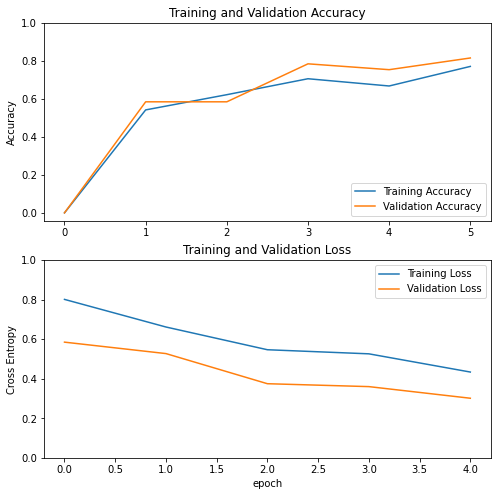

In [17]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

###  Fine-tuning the Model

In [18]:
base_model = model2.layers[4]
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)

metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  155


In [19]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 5s 600ms/step - loss: 0.6059 - accuracy: 0.7023 - val_loss: 0.2723 - val_accuracy: 0.9538
Epoch 6/10
9/9 [==============================] - 5s 546ms/step - loss: 0.4255 - accuracy: 0.7519 - val_loss: 0.2114 - val_accuracy: 0.9692
Epoch 7/10
9/9 [==============================] - 5s 512ms/step - loss: 0.3107 - accuracy: 0.8779 - val_loss: 0.2091 - val_accuracy: 0.8615
Epoch 8/10
9/9 [==============================] - 5s 512ms/step - loss: 0.2165 - accuracy: 0.9122 - val_loss: 0.1156 - val_accuracy: 0.9538
Epoch 9/10
9/9 [==============================] - 5s 507ms/step - loss: 0.1552 - accuracy: 0.9389 - val_loss: 0.0991 - val_accuracy: 0.9692
Epoch 10/10
9/9 [==============================] - 5s 508ms/step - loss: 0.1692 - accuracy: 0.9160 - val_loss: 0.0753 - val_accuracy: 0.9846


In [20]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

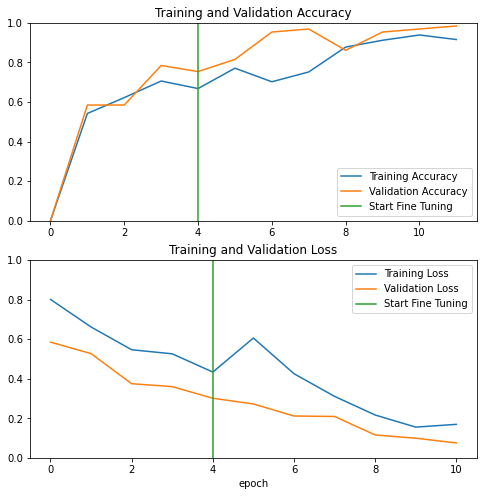

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()